In [1]:
import os,sys
sys.path.append("../src/")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from visualizations import plot_feature_boxplots, plot_feature_histograms
from language import *

plt.rcParams.update({'font.size': 12})

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Loading data

In [2]:
# Loading the data
df_train = pd.read_csv('../data/Social Bias Frames/SBIC.v2.trn.csv')
df_valid = pd.read_csv('../data/Social Bias Frames/SBIC.v2.dev.csv')
df_test = pd.read_csv('../data/Social Bias Frames/SBIC.v2.tst.csv')

### Data Fields
The data fields are the same among all splits.

#### default
- whoTarget: a string, ‘0.0’ if the target is a group, ‘1.0’ if the target is an individual, and blank if the post is not offensive
- intentYN: a string indicating if the intent behind the statement was to offend. This is a categorical variable with four possible answers, ‘1.0’ if yes, ‘0.66’ if probably, ‘0.33’ if probably not, and ‘0.0’ if no.
- sexYN: a string indicating whether the post contains a sexual or lewd reference. This is a categorical variable with three possible answers, ‘1.0’ if yes, ‘0.5’ if maybe, ‘0.0’ if no.
- sexReason: a string containing a free text explanation of what is sexual if indicated so, blank otherwise
- offensiveYN: a string indicating if the post could be offensive to anyone. This is a categorical variable with three possible answers, ‘1.0’ if yes, ‘0.5’ if maybe, ‘0.0’ if no.
- annotatorGender: a string indicating the gender of the MTurk worker
- annotatorMinority: a string indicating whether the MTurk worker identifies as a minority
- sexPhrase: a string indicating which part of the post references something sexual, blank otherwise
- speakerMinorityYN: a string indicating whether the speaker was part of the same minority group that's being targeted. This is a categorical variable with three possible answers, ‘1.0’ if yes, ‘0.5’ if maybe, ‘0.0’ if no.
- WorkerId: a string hashed version of the MTurk workerId
- HITId: a string id that uniquely identifies each post
- annotatorPolitics: a string indicating the political leaning of the MTurk worker
- annotatorRace: a string indicating the race of the MTurk worker
- annotatorAge: a string indicating the age of the MTurk worker
- post: a string containing the text of the post that was annotated
- targetMinority: a string indicating the demographic group targeted
- targetCategory: a string indicating the high-level category of the demographic group(s) targeted
- targetStereotype: a string containing the implied statement
- dataSource: a string indicating the source of the post (t/...: means Twitter, r/...: means a subreddit)

In [3]:
df_train

,whoTarget,intentYN,sexYN,sexReason,offensiveYN,annotatorGender,annotatorMinority,sexPhrase,speakerMinorityYN,WorkerId,HITId,annotatorPolitics,annotatorRace,annotatorAge,post,targetMinority,targetCategory,targetStereotype,dataSource
0,0.0,0.66,0.0,NaN,1.0,woman,NaN,NaN,NaN,-8935932304856669427,363A7XIFV4G2799C5V96YERJA9AVAM,liberal,white,45.0,RT @_LexC__: I'm convinced that some of y'all ...,NaN,NaN,NaN,t/davidson
1,0.0,0.66,0.0,NaN,0.5,man,NaN,NaN,NaN,6347880360297734464,363A7XIFV4G2799C5V96YERJA9AVAM,mod-liberal,white,35.0,RT @_LexC__: I'm convinced that some of y'all ...,NaN,NaN,NaN,t/davidson
2,0.0,0.33,0.0,NaN,0.5,man,NaN,NaN,NaN,-7452610791699819066,363A7XIFV4G2799C5V96YERJA9AVAM,liberal,asian,23.0,RT @_LexC__: I'm convinced that some of y'all ...,NaN,NaN,NaN,t/davidson
3,1.0,1.00,0.0,NaN,1.0,man,NaN,NaN,0.0,-500114755446676507,3JTPR5MTZS6RLS3JBV4IOU0G2X35K5,liberal,white,25.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,all stupid,t/davidson
4,1.0,1.00,0.0,NaN,1.0,man,NaN,NaN,0.0,-500114755446676507,3JTPR5MTZS6RLS3JBV4IOU0G2X35K5,liberal,white,25.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,are not people but apes.,t/davidson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112895,0.0,0.33,0.0,NaN,1.0,na,NaN,NaN,NaN,1558992385113521549,3G57RS03HHZW4CZTMPYEOYEMNVI25F,na,na,35.0,Thought you fellas might like to explain to so...,NaN,NaN,NaN,r/MensRights
112896,NaN,0.00,0.0,NaN,0.0,man,NaN,NaN,NaN,-5870881806826799680,3G57RS03HHZW4CZTMPYEOYEMNVI25F,liberal,white,35.0,Thought you fellas might like to explain to so...,NaN,NaN,NaN,r/MensRights
112897,NaN,0.00,0.0,NaN,0.0,man,pacific islander,NaN,NaN,-768683606829583421,38O9DZ0A62HSNGZ7R88JG4SMJQT26V,liberal,other,36.0,"If female voters were discounted, Labour would...",NaN,NaN,NaN,r/MensRights
112898,NaN,0.00,0.0,NaN,0.0,man,NaN,NaN,NaN,-5870881806826799680,38O9DZ0A62HSNGZ7R88JG4SMJQT26V,liberal,white,35.0,"If female voters were discounted, Labour would...",NaN,NaN,NaN,r/MensRights


## Data Exploration

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112900 entries, 0 to 112899
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   whoTarget          65969 non-null   float64
 1   intentYN           112900 non-null  float64
 2   sexYN              112900 non-null  float64
 3   sexReason          10380 non-null   object 
 4   offensiveYN        110883 non-null  float64
 5   annotatorGender    112899 non-null  object 
 6   annotatorMinority  29030 non-null   object 
 7   sexPhrase          10393 non-null   object 
 8   speakerMinorityYN  45463 non-null   float64
 9   WorkerId           112900 non-null  int64  
 10  HITId              112900 non-null  object 
 11  annotatorPolitics  112899 non-null  object 
 12  annotatorRace      112899 non-null  object 
 13  annotatorAge       112899 non-null  float64
 14  post               112900 non-null  object 
 15  targetMinority     42494 non-null   object 
 16  ta

In [5]:
# Creating some features
df_train['post_length'] = df_train['post'].apply(lambda x: len(x))
df_train['post_length_no_spaces'] = df_train['post'].apply(lambda x: len(x) - x.count(" "))

In [6]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
whoTarget,65969.0,6.439388e-01,4.788372e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
intentYN,112900.0,5.098538e-01,4.377631e-01,0.000000e+00,0.000000e+00,6.600000e-01,1.000000e+00,1.000000e+00
sexYN,112900.0,8.783880e-02,2.798754e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
offensiveYN,110883.0,5.340223e-01,4.757271e-01,0.000000e+00,0.000000e+00,5.000000e-01,1.000000e+00,1.000000e+00
speakerMinorityYN,45463.0,5.454985e-02,1.888410e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
WorkerId,112900.0,-1.331461e+17,5.216958e+18,-9.147217e+18,-4.972503e+18,8.023572e+17,4.224836e+18,9.197612e+18
annotatorAge,112899.0,3.343147e+01,8.577052e+00,1.800000e+01,2.800000e+01,3.300000e+01,3.700000e+01,1.000000e+02
post_length,112900.0,1.093404e+02,6.195705e+01,2.000000e+00,7.100000e+01,1.010000e+02,1.330000e+02,1.217000e+03
post_length_no_spaces,112900.0,9.032080e+01,5.087863e+01,2.000000e+00,5.900000e+01,8.400000e+01,1.100000e+02,1.002000e+03


In [7]:
for col in df_train.columns:
    value_counts = df_train[col].value_counts(dropna=False)
    print(col+' |', value_counts.shape[0], 'unique values |', df_train[col].isnull().sum(), 'nulls values')

whoTarget | 3 unique values | 46931 nulls values
intentYN | 4 unique values | 0 nulls values
sexYN | 3 unique values | 0 nulls values
sexReason | 4264 unique values | 102520 nulls values
offensiveYN | 4 unique values | 2017 nulls values
annotatorGender | 6 unique values | 1 nulls values
annotatorMinority | 68 unique values | 83870 nulls values
sexPhrase | 5639 unique values | 102507 nulls values
speakerMinorityYN | 4 unique values | 67437 nulls values
WorkerId | 263 unique values | 0 nulls values
HITId | 35933 unique values | 0 nulls values
annotatorPolitics | 8 unique values | 1 nulls values
annotatorRace | 8 unique values | 1 nulls values
annotatorAge | 50 unique values | 1 nulls values
post | 35504 unique values | 0 nulls values
targetMinority | 1180 unique values | 70406 nulls values
targetCategory | 8 unique values | 70406 nulls values
targetStereotype | 24086 unique values | 71192 nulls values
dataSource | 12 unique values | 0 nulls values
post_length | 544 unique values | 0 null

In [20]:
df_train['targetCategory'].value_counts(dropna=False)

NaN         70406
race        14987
gender      10872
culture      8843
victim       2680
disabled     2350
social       1730
body         1032
Name: targetCategory, dtype: int64

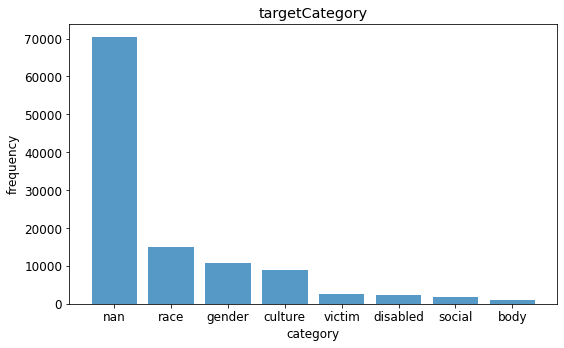

In [8]:
counts = df_train['targetCategory'].value_counts(dropna=False)

plt.figure(figsize=(8, 5))
plt.title('targetCategory')
xticks = [x for x in range(counts.index.shape[0])]
plt.bar(xticks, counts.values, alpha=0.75)
plt.xticks(xticks, counts.index)
plt.ylabel("frequency")
plt.xlabel("category")
plt.tight_layout()
plt.show()

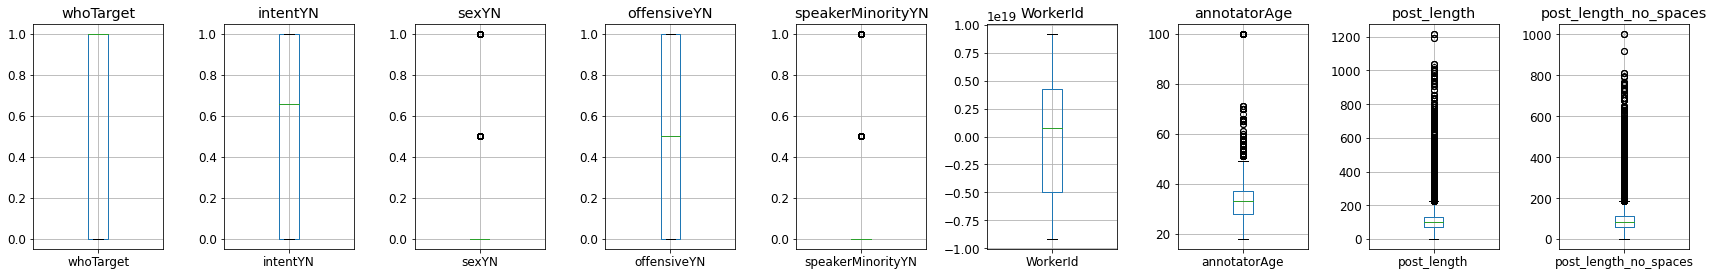

In [9]:
# Boxplots:
boxplot_cols = df_train.describe().columns
plot_feature_boxplots(df_train, boxplot_cols, figsize=(24, 4))

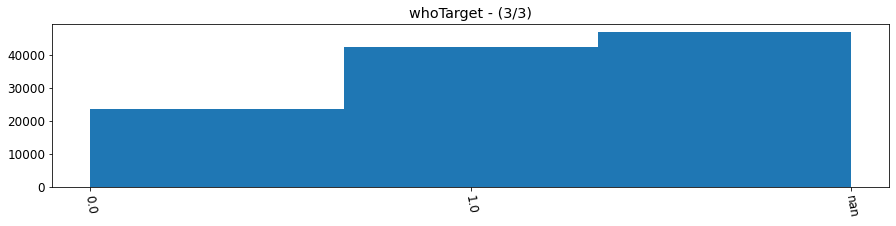

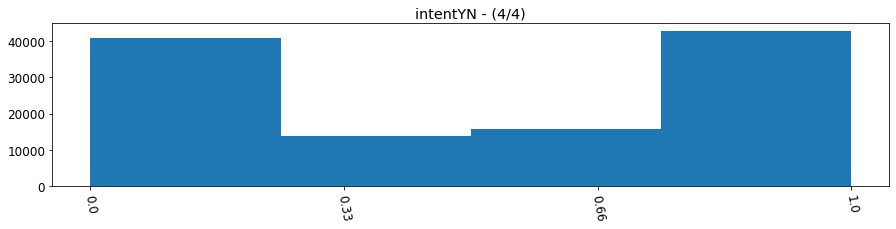

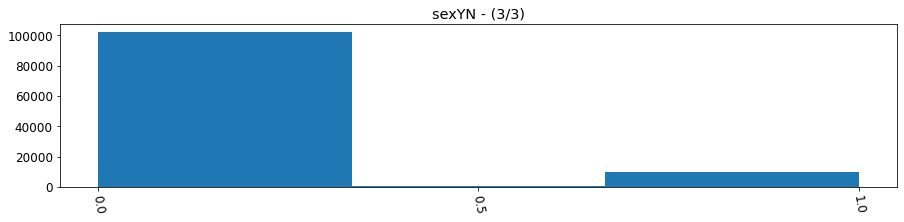

../src\preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_[col][~np.isin(x_df[col], self.major_categories[col])] = self.minor_label


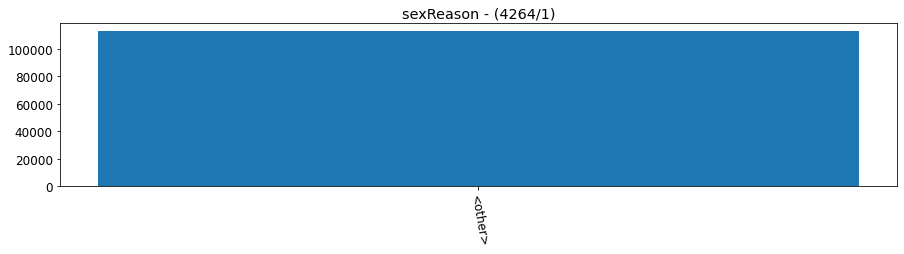

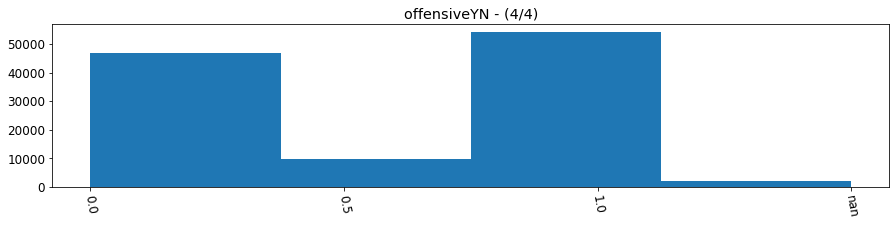

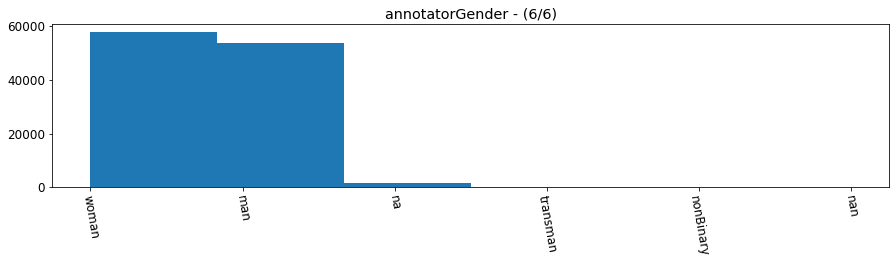

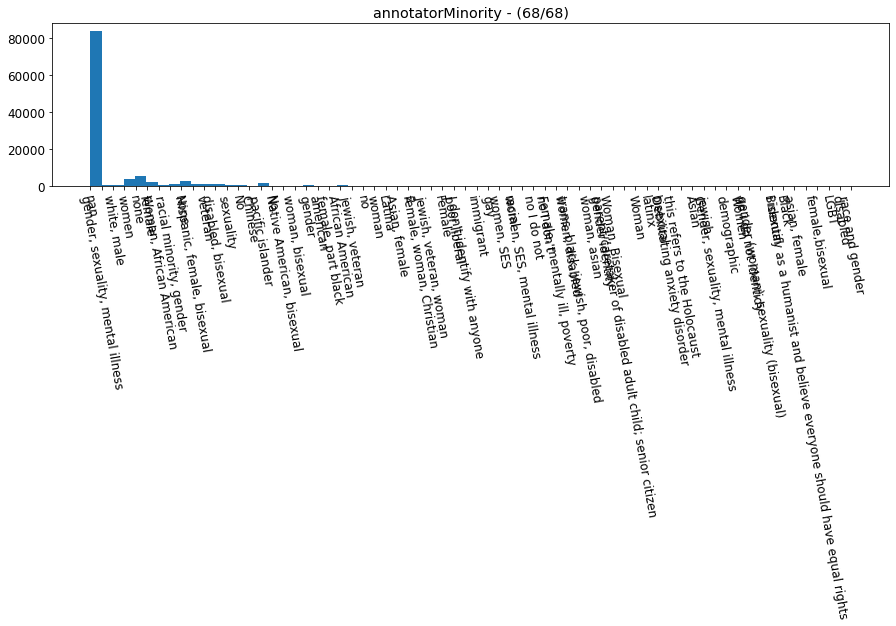

../src\preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_[col][~np.isin(x_df[col], self.major_categories[col])] = self.minor_label


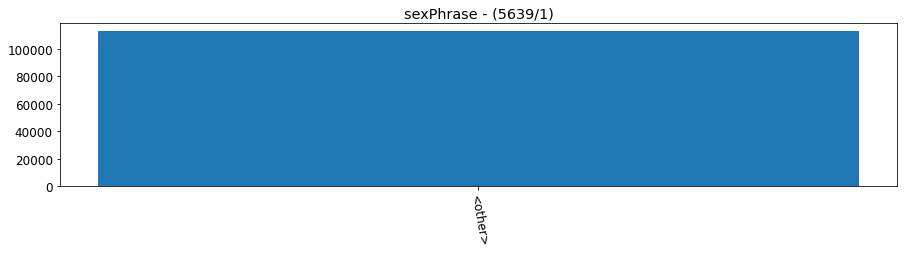

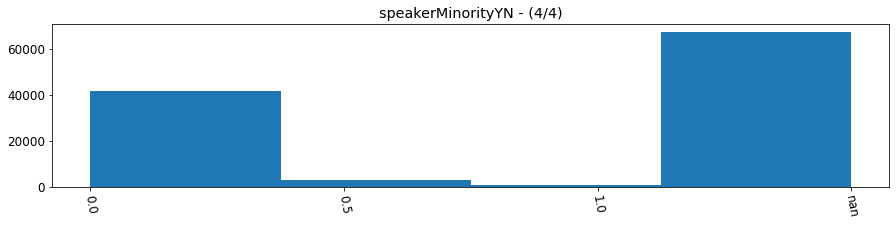

../src\preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_[col][~np.isin(x_df[col], self.major_categories[col])] = self.minor_label


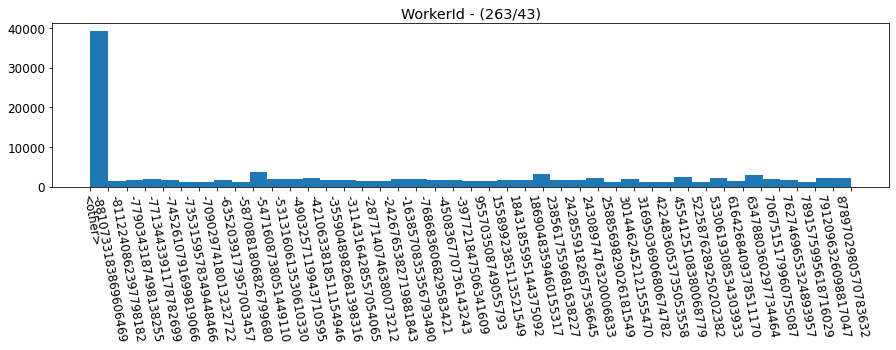

../src\preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_[col][~np.isin(x_df[col], self.major_categories[col])] = self.minor_label


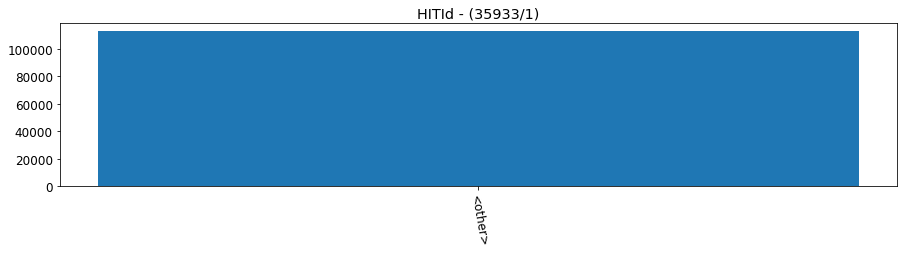

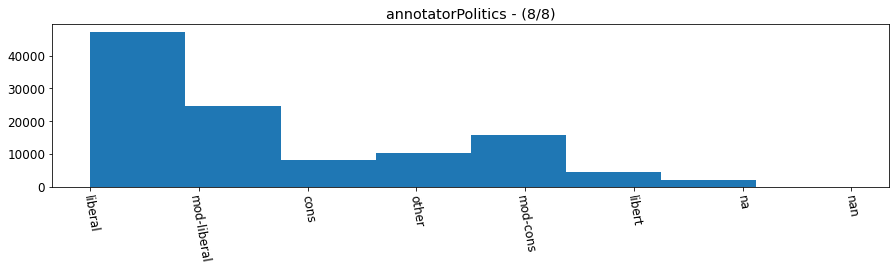

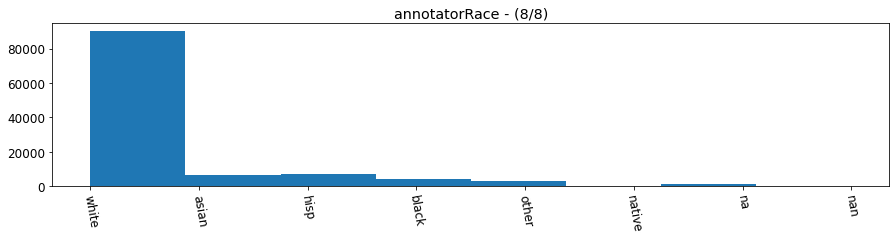

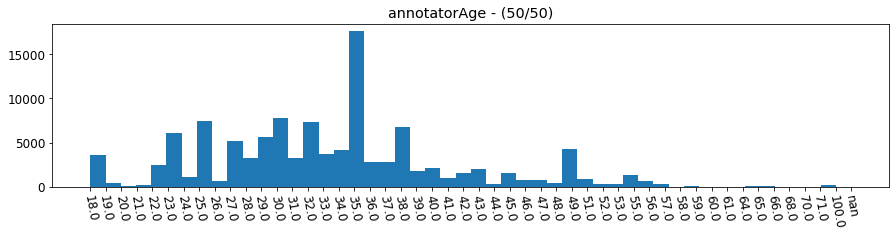

../src\preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_[col][~np.isin(x_df[col], self.major_categories[col])] = self.minor_label


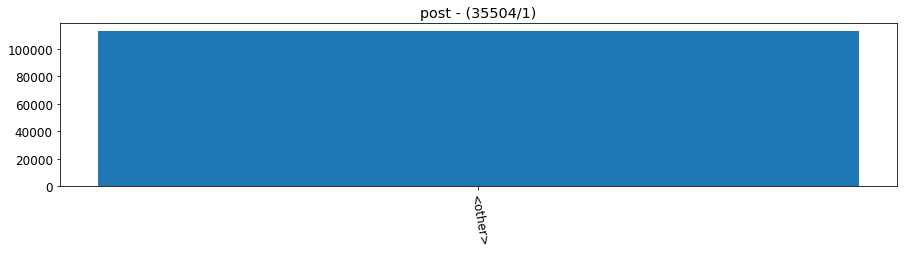

../src\preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_[col][~np.isin(x_df[col], self.major_categories[col])] = self.minor_label


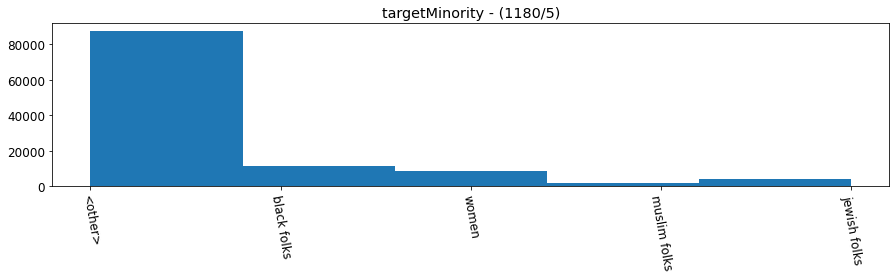

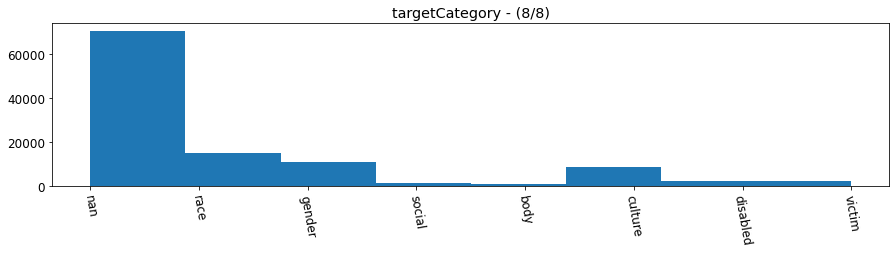

../src\preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_[col][~np.isin(x_df[col], self.major_categories[col])] = self.minor_label


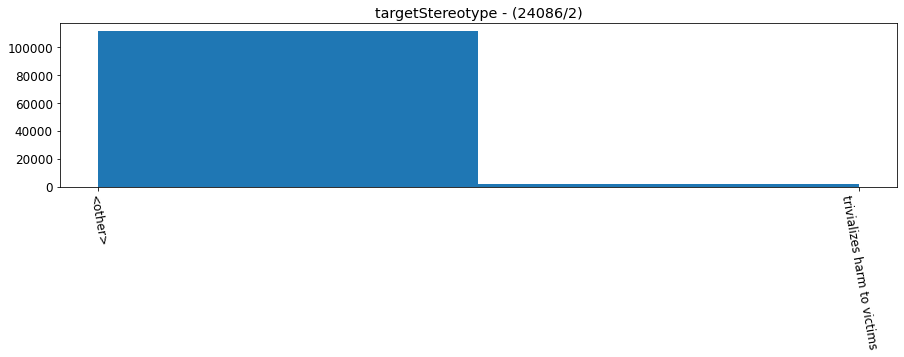

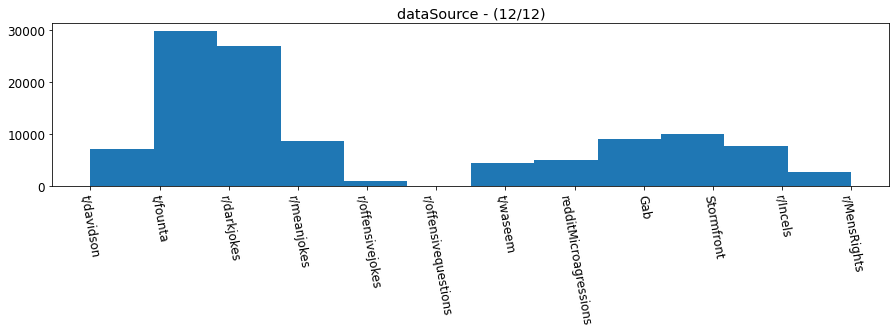

../src\preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_[col][~np.isin(x_df[col], self.major_categories[col])] = self.minor_label


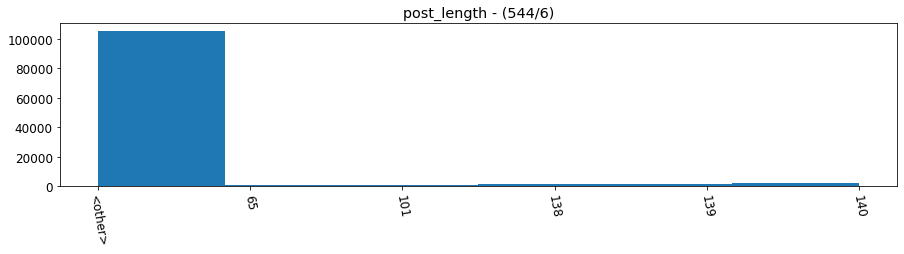

../src\preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_[col][~np.isin(x_df[col], self.major_categories[col])] = self.minor_label


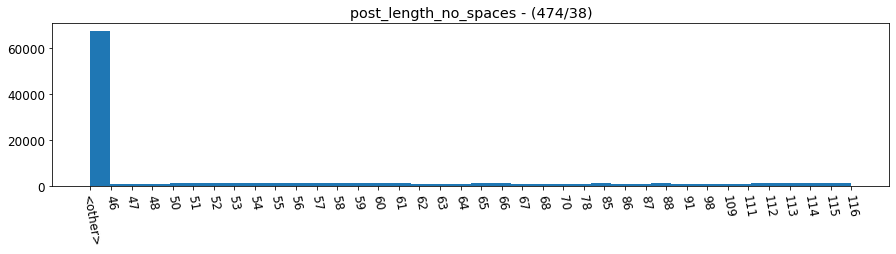

In [10]:
# Histogram:
histogram_cols = df_train.columns
plot_feature_histograms(df_train, histogram_cols, major_cat_perc=0.01)

## Data Preparation

In [11]:
df_sample = df_train.sample(50)

for post, source, category in zip(df_sample['post'], df_sample['dataSource'], df_sample['targetCategory']):
    print(f'{category}: {post} ({source})')

nan: I rlly just need to get drunk alone and cry but I can't even afford alcohol because I've had 3 fucking tables today (t/founta)
race: Niggas be GROWN as hell STILL splitting bills with they mans,but can't even eat a steak without shaking the table. (t/founta)
nan: MJ: B*tch, better have my money. James: Wait, what??? Not Nadine, @mjfelipe ✌&#127995;️✌&#127995;&#128514;&#128514;&#128514; #JaDineFearlessNotCareless (t/founta)
nan: studentcels, how was the first week of school? (r/Incels)
nan: Saw three GROWN men on a motorcycle &amp; that bitch was barely moving lmao what the hell (t/davidson)
nan: How you gone wife a bitch that let niggas lick on her head in public? (t/davidson)
nan: @Iromg @mikeparry8 give him a chance MG ffs.. Do a quiz on slippers.. PS please do a show with hooked up to a polygraph.. Would be gold (t/founta)
nan: OKAY BUT I JUST REALLY REALLY WANT WONWOO TO EAT WELL AND GAIN SOME MUSCLE BECAUSE THATD BE SO GOOD HIS HEALTH. PLEASE. (t/founta)
victim: Walked into m

In [12]:
# Remove accents:
df_train['post_clean_accents'] = df_train['post'].apply(lambda x: strip_accents(x))
df_train[['post', 'post_clean_accents']].head()

,post,post_clean_accents
0,RT @_LexC__: I'm convinced that some of y'all ...,RT @_LexC__: I'm convinced that some of y'all ...
1,RT @_LexC__: I'm convinced that some of y'all ...,RT @_LexC__: I'm convinced that some of y'all ...
2,RT @_LexC__: I'm convinced that some of y'all ...,RT @_LexC__: I'm convinced that some of y'all ...
3,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT @iBeZo: Stupid fucking nigger LeBron. You f...
4,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT @iBeZo: Stupid fucking nigger LeBron. You f...


In [13]:
# Remove punctuation:
df_train['post_clean_accents_punct'] = df_train['post_clean_accents'].apply(lambda x: remove_punct(x))
df_train[['post', 'post_clean_accents', 'post_clean_accents_punct']].head()

,post,post_clean_accents,post_clean_accents_punct
0,RT @_LexC__: I'm convinced that some of y'all ...,RT @_LexC__: I'm convinced that some of y'all ...,RT LexC Im convinced that some of yall bitches...
1,RT @_LexC__: I'm convinced that some of y'all ...,RT @_LexC__: I'm convinced that some of y'all ...,RT LexC Im convinced that some of yall bitches...
2,RT @_LexC__: I'm convinced that some of y'all ...,RT @_LexC__: I'm convinced that some of y'all ...,RT LexC Im convinced that some of yall bitches...
3,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT iBeZo Stupid fucking nigger LeBron You flop...
4,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT iBeZo Stupid fucking nigger LeBron You flop...


In [14]:
# Tokenization and convert to lower case:
df_train['post_tokenized'] = df_train['post_clean_accents_punct'].apply(lambda x: tokenize(x))
df_train[['post', 'post_clean_accents', 'post_clean_accents_punct', 'post_tokenized']].head()

,post,post_clean_accents,post_clean_accents_punct,post_tokenized
0,RT @_LexC__: I'm convinced that some of y'all ...,RT @_LexC__: I'm convinced that some of y'all ...,RT LexC Im convinced that some of yall bitches...,"[rt, lexc, im, convinced, that, some, of, yall..."
1,RT @_LexC__: I'm convinced that some of y'all ...,RT @_LexC__: I'm convinced that some of y'all ...,RT LexC Im convinced that some of yall bitches...,"[rt, lexc, im, convinced, that, some, of, yall..."
2,RT @_LexC__: I'm convinced that some of y'all ...,RT @_LexC__: I'm convinced that some of y'all ...,RT LexC Im convinced that some of yall bitches...,"[rt, lexc, im, convinced, that, some, of, yall..."
3,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT iBeZo Stupid fucking nigger LeBron You flop...,"[rt, ibezo, stupid, fucking, nigger, lebron, y..."
4,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT iBeZo Stupid fucking nigger LeBron You flop...,"[rt, ibezo, stupid, fucking, nigger, lebron, y..."


In [15]:
# Remove stopwords:
en_stopwords = stopwords.words('english')
df_train['post_nostop'] = df_train['post_tokenized'].apply(lambda x: remove_stopwords(x, en_stopwords))
df_train[['post', 'post_clean_accents', 'post_clean_accents_punct', 'post_tokenized', 'post_nostop']].head()

,post,post_clean_accents,post_clean_accents_punct,post_tokenized,post_nostop
0,RT @_LexC__: I'm convinced that some of y'all ...,RT @_LexC__: I'm convinced that some of y'all ...,RT LexC Im convinced that some of yall bitches...,"[rt, lexc, im, convinced, that, some, of, yall...","[rt, lexc, im, convinced, yall, bitches, get, ..."
1,RT @_LexC__: I'm convinced that some of y'all ...,RT @_LexC__: I'm convinced that some of y'all ...,RT LexC Im convinced that some of yall bitches...,"[rt, lexc, im, convinced, that, some, of, yall...","[rt, lexc, im, convinced, yall, bitches, get, ..."
2,RT @_LexC__: I'm convinced that some of y'all ...,RT @_LexC__: I'm convinced that some of y'all ...,RT LexC Im convinced that some of yall bitches...,"[rt, lexc, im, convinced, that, some, of, yall...","[rt, lexc, im, convinced, yall, bitches, get, ..."
3,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT iBeZo Stupid fucking nigger LeBron You flop...,"[rt, ibezo, stupid, fucking, nigger, lebron, y...","[rt, ibezo, stupid, fucking, nigger, lebron, f..."
4,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT iBeZo Stupid fucking nigger LeBron You flop...,"[rt, ibezo, stupid, fucking, nigger, lebron, y...","[rt, ibezo, stupid, fucking, nigger, lebron, f..."


In [16]:
# Stemming:
df_train['post_stemmed'] = df_train['post_nostop'].apply(lambda x: stemming(x))
df_train[['post', 'post_clean_accents', 'post_clean_accents_punct', 'post_tokenized', 'post_nostop', 'post_stemmed']].head()

,post,post_clean_accents,post_clean_accents_punct,post_tokenized,post_nostop,post_stemmed
0,RT @_LexC__: I'm convinced that some of y'all ...,RT @_LexC__: I'm convinced that some of y'all ...,RT LexC Im convinced that some of yall bitches...,"[rt, lexc, im, convinced, that, some, of, yall...","[rt, lexc, im, convinced, yall, bitches, get, ...","[rt, lexc, im, convinced, yall, bitch, get, pr..."
1,RT @_LexC__: I'm convinced that some of y'all ...,RT @_LexC__: I'm convinced that some of y'all ...,RT LexC Im convinced that some of yall bitches...,"[rt, lexc, im, convinced, that, some, of, yall...","[rt, lexc, im, convinced, yall, bitches, get, ...","[rt, lexc, im, convinced, yall, bitch, get, pr..."
2,RT @_LexC__: I'm convinced that some of y'all ...,RT @_LexC__: I'm convinced that some of y'all ...,RT LexC Im convinced that some of yall bitches...,"[rt, lexc, im, convinced, that, some, of, yall...","[rt, lexc, im, convinced, yall, bitches, get, ...","[rt, lexc, im, convinced, yall, bitch, get, pr..."
3,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT iBeZo Stupid fucking nigger LeBron You flop...,"[rt, ibezo, stupid, fucking, nigger, lebron, y...","[rt, ibezo, stupid, fucking, nigger, lebron, f...","[rt, ibez, stupid, fucking, nigg, lebron, flop..."
4,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT iBeZo Stupid fucking nigger LeBron You flop...,"[rt, ibezo, stupid, fucking, nigger, lebron, y...","[rt, ibezo, stupid, fucking, nigger, lebron, f...","[rt, ibez, stupid, fucking, nigg, lebron, flop..."


In [17]:
# Lemmatizer:
df_train['post_lemmatized'] = df_train['post_nostop'].apply(lambda x: lemmatizing(x))
df_train[['post', 'post_clean_accents', 'post_clean_accents_punct', 'post_tokenized', 'post_nostop', 'post_lemmatized']].head()

,post,post_clean_accents,post_clean_accents_punct,post_tokenized,post_nostop,post_lemmatized
0,RT @_LexC__: I'm convinced that some of y'all ...,RT @_LexC__: I'm convinced that some of y'all ...,RT LexC Im convinced that some of yall bitches...,"[rt, lexc, im, convinced, that, some, of, yall...","[rt, lexc, im, convinced, yall, bitches, get, ...","[rt, lexc, im, convinced, yall, bitch, get, pr..."
1,RT @_LexC__: I'm convinced that some of y'all ...,RT @_LexC__: I'm convinced that some of y'all ...,RT LexC Im convinced that some of yall bitches...,"[rt, lexc, im, convinced, that, some, of, yall...","[rt, lexc, im, convinced, yall, bitches, get, ...","[rt, lexc, im, convinced, yall, bitch, get, pr..."
2,RT @_LexC__: I'm convinced that some of y'all ...,RT @_LexC__: I'm convinced that some of y'all ...,RT LexC Im convinced that some of yall bitches...,"[rt, lexc, im, convinced, that, some, of, yall...","[rt, lexc, im, convinced, yall, bitches, get, ...","[rt, lexc, im, convinced, yall, bitch, get, pr..."
3,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT iBeZo Stupid fucking nigger LeBron You flop...,"[rt, ibezo, stupid, fucking, nigger, lebron, y...","[rt, ibezo, stupid, fucking, nigger, lebron, f...","[rt, ibezo, stupid, fucking, nigger, lebron, f..."
4,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT @iBeZo: Stupid fucking nigger LeBron. You f...,RT iBeZo Stupid fucking nigger LeBron You flop...,"[rt, ibezo, stupid, fucking, nigger, lebron, y...","[rt, ibezo, stupid, fucking, nigger, lebron, f...","[rt, ibezo, stupid, fucking, nigger, lebron, f..."


In [18]:
for text, text_stem, text_lemm in zip(df_train['post'][0:50], df_train['post_stemmed'], df_train['post_lemmatized']):
    print('\ntext:', text)
    print('stem:', text_stem)
    print('lemm:', text_lemm)


text: RT @_LexC__: I'm convinced that some of y'all bitches get pregnant purposely because "birth control &amp; plan b pills" are effective &#128533;&#128056;&#9749;&#65039;
stem: ['rt', 'lexc', 'im', 'convinced', 'yall', 'bitch', 'get', 'pregnant', 'purposely', 'birth', 'control', 'amp', 'plan', 'b', 'pill', 'effectiv', '128533128056974965039']
lemm: ['rt', 'lexc', 'im', 'convinced', 'yall', 'bitch', 'get', 'pregnant', 'purposely', 'birth', 'control', 'amp', 'plan', 'b', 'pill', 'effective', '128533128056974965039']

text: RT @_LexC__: I'm convinced that some of y'all bitches get pregnant purposely because "birth control &amp; plan b pills" are effective &#128533;&#128056;&#9749;&#65039;
stem: ['rt', 'lexc', 'im', 'convinced', 'yall', 'bitch', 'get', 'pregnant', 'purposely', 'birth', 'control', 'amp', 'plan', 'b', 'pill', 'effectiv', '128533128056974965039']
lemm: ['rt', 'lexc', 'im', 'convinced', 'yall', 'bitch', 'get', 'pregnant', 'purposely', 'birth', 'control', 'amp', 'plan', 'b'

## Vectorizing Data:

In [19]:
# TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer=clean_text_lemmatize, max_features=100)
X_tfidf = tfidf_vect.fit_transform(df_train['post'][0:1000])

print(X_tfidf.shape)
print(tfidf_vect.get_feature_names())

(1000, 100)
['a bitch', 'a hoe', 'a nigga', 'about how', 'aint', 'aint shit', 'all the', 'amp', 'as', 'bad', 'be so', 'better', 'bitch', 'bitches be', 'call', 'cant', 'cause', 'come', 'crazy', 'da', 'day', 'dont', 'em', 'even', 'faggot', 'fuck', 'fucking', 'gay', 'get', 'ghetto', 'girl', 'go', 'going', 'going to', 'good', 'got', 'guy', 'hate', 'hit', 'hoe', 'i dont', 'i have', 'if you', 'im', 'in the', 'know', 'let', 'like', 'like a', 'lol', 'look', 'love', 'mad', 'make', 'man', 'monkey', 'need', 'new', 'nigga', 'niggaz', 'nigger', 'no no', 'of the', 'on the', 'one', 'people', 'pussy', 'put', 'really', 'republican', 'retard', 'retarded', 'rt', 'said', 'see', 'shit', 'shoot', 'smh', 'still', 'stupid', 'talk', 'tell', 'thats', 'the bitches', 'the same', 'these bitches', 'these hoes', 'to be', 'trash', 'u', 'ugly', 'wanna', 'want', 'white', 'wit', 'with a', 'would', 'ya', 'yall', 'youre']
